Test MAE:  49,151.53 USD
Test RMSE: 159,673.26 USD
R²: 0.8438


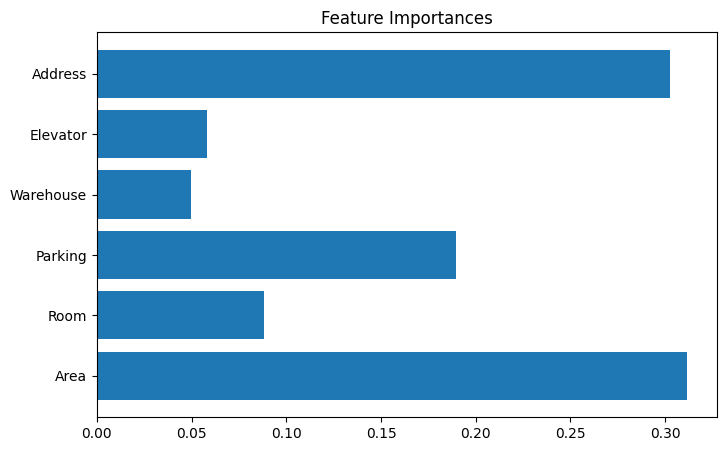

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import category_encoders as ce

df = pd.read_csv('housePrice.csv')

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except (ValueError, TypeError):
        pass


df['Area'] = pd.to_numeric(df['Area'], errors='coerce')
df['Area'] = df['Area'].fillna(df['Area'].median())

bin_cols = ['Room', 'Parking', 'Warehouse', 'Elevator']
df[bin_cols] = df[bin_cols].fillna(df[bin_cols].mode().iloc[0])

df = df.drop(columns=['Price'])
df['Price(USD)'] = pd.to_numeric(df['Price(USD)'], errors='coerce')
df['Price(USD)'] = df['Price(USD)'].fillna(df['Price(USD)'].median())
df['Price(USD)'] = np.log1p(df['Price(USD)'])


df['Address'] = df['Address'].fillna('Unknown').astype(str)

X = df[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address']]
y = df['Price(USD)']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


encoder = ce.TargetEncoder(cols=['Address'], smoothing=0.3)
encoder.fit(X_train, y_train)
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

model.fit(X_train_encoded, y_train, eval_set=[(X_test_encoded, y_test)], verbose=False)


y_pred = model.predict(X_test_encoded)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print(f"Test MAE:  {mae:,.2f} USD")
print(f"Test RMSE: {rmse:,.2f} USD")
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")


plt.figure(figsize=(8, 5))
plt.barh(X_train_encoded.columns, model.feature_importances_)
plt.title("Feature Importances")
plt.show()

Unique addresses after grouping: 46

Test MAE:  45,666.28 USD
Test RMSE: 140,290.86 USD
R²: 0.8718


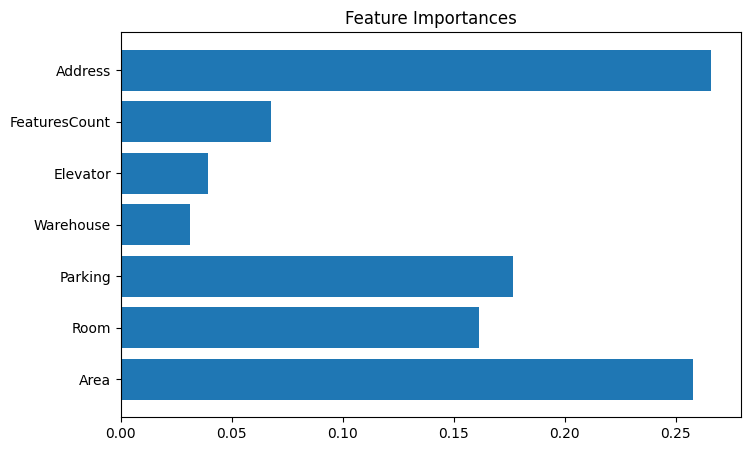

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import category_encoders as ce

df = pd.read_csv('housePrice.csv')


for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except (ValueError, TypeError):
        pass


df['Area'] = pd.to_numeric(df['Area'], errors='coerce')
df['Area'] = df['Area'].fillna(df['Area'].median())


bin_cols = ['Room', 'Parking', 'Warehouse', 'Elevator']
df[bin_cols] = df[bin_cols].fillna(df[bin_cols].mode().iloc[0])


df = df.drop(columns=['Price'])


df['Price(USD)'] = pd.to_numeric(df['Price(USD)'], errors='coerce')
df['Price(USD)'] = df['Price(USD)'].fillna(df['Price(USD)'].median())
df['Price(USD)'] = np.log1p(df['Price(USD)'])  # log-transform


df['Address'] = df['Address'].fillna('Unknown').astype(str)

df['Area'] = np.log1p(df['Area'])


address_counts = df['Address'].value_counts()
rare_addresses = address_counts[address_counts < 20].index  # threshold can be tuned
df['Address'] = df['Address'].replace(rare_addresses, 'Other')

print("Unique addresses after grouping:", df['Address'].nunique())

df['FeaturesCount'] = df[['Parking', 'Warehouse', 'Elevator']].sum(axis=1)

X = df[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'FeaturesCount', 'Address']]
y = df['Price(USD)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = ce.TargetEncoder(cols=['Address'], smoothing=0.3)
encoder.fit(X_train, y_train)
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    early_stopping_rounds=200,
)

model.fit(
    X_train_encoded,
    y_train,
    eval_set=[(X_test_encoded, y_test)],
    verbose=False
)

y_pred = model.predict(X_test_encoded)

mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

from sklearn.metrics import r2_score
print(f"\nTest MAE:  {mae:,.2f} USD")
print(f"Test RMSE: {rmse:,.2f} USD")
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

plt.figure(figsize=(8, 5))
plt.barh(X_train_encoded.columns, model.feature_importances_)
plt.title("Feature Importances")
plt.show()
